In [224]:
###########
## Can you estimate cassava root volume from underground scanning images?
## [Challenge source URL](https://zindi.africa/competitions/cgiar-root-volume-estimation-challenge)
##########

In this challenge, your goal is to estimate the root volume of different cassava plant varieties using a set of images that depict these different types. You will use computer vision and machine learning techniques to develop a robust, generalisable machine learning model for root volume estimation.

In [280]:
import time
start = time.time()

In [225]:
!pip install lightning -q

In [226]:
import numpy as np
import lightning as L
import torch
# set seed for reproducibility
def seed_everything(seed):
    np.random.seed(42)
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
    L.pytorch.seed_everything(seed, workers=True)
    
seed_everything(42)

INFO: Seed set to 42


In [227]:
# Define global path for GPR scanned-images
from pathlib import Path
TRAIN_DATA_PATH = Path('/kaggle/input/zindi-cgiar-files/data/train')
TEST_DATA_PATH = Path('/kaggle/input/zindi-cgiar-files/data/test')

In [228]:
import pandas as pd
# Read train, test data & sample submission
train_data = pd.read_csv("/kaggle/input/zindi-cgiar-files/Train.csv")
test_data = pd.read_csv("/kaggle/input/zindi-cgiar-files/Test.csv")
submission_data = pd.read_csv("/kaggle/input/zindi-cgiar-files/Sample_Submission.csv")

In [229]:
# Copy ID's
ID = test_data.ID
ID

0      ID_208667_Hnkl8q
1      ID_285249_Jnjvav
2      ID_697947_Yec6bd
3      ID_534638_X3j91f
4      ID_929298_Xvymuz
             ...       
125    ID_652025_Ecubfg
126    ID_456856_Iucagp
127    ID_163551_Alfdb5
128    ID_947929_Qsuqln
129    ID_225470_Hju47r
Name: ID, Length: 130, dtype: object

In [230]:
# display train first 5 rows
train_data.head()

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early


In [231]:
# display test first 5 rows
test_data.head()

,ID,FolderName,PlantNumber,Side,Start,End,Genotype,Stage
0,ID_208667_Hnkl8q,L5l1h3kekg,7,L,38,50,IITA-TMS-IBA000070,Early
1,ID_285249_Jnjvav,Wgutyon8uu,6,R,23,37,TMEB419,Early
2,ID_697947_Yec6bd,Mylwjeq6tq,3,R,19,42,IBA980581,Early
3,ID_534638_X3j91f,Pfp24vx905,2,R,27,34,TMEB419,Early
4,ID_929298_Xvymuz,Mrw7chmalv,4,R,30,43,IBA154810,Early


In [232]:
# display submission first 5 rows
submission_data.head()

,ID,RootVolume
0,ID_208667_Hnkl8q,0
1,ID_285249_Jnjvav,0
2,ID_697947_Yec6bd,0
3,ID_534638_X3j91f,0
4,ID_929298_Xvymuz,0


In [233]:
# Dimensions (rows, columns)
train_data.shape, test_data.shape, submission_data.shape

((386, 9), (130, 8), (130, 2))

In [234]:
# Print summary statistics
train_data.describe()

,PlantNumber,Start,End,RootVolume
count,386.000000,386.000000,386.000000,386.000000
mean,3.974093,27.018135,36.989637,2.052306
std,1.508195,8.234686,7.960611,1.526302
min,1.000000,8.000000,14.000000,0.000000
25%,3.000000,22.000000,32.000000,0.900000
50%,4.000000,26.000000,37.000000,1.900000
75%,5.000000,32.000000,42.000000,2.700000
max,7.000000,49.000000,60.000000,11.000000


In [235]:
# Modality for a Stage column
display(train_data['Stage'].value_counts())
print('\n')
display(test_data['Stage'].value_counts())

Stage
Early    370
Late      16
Name: count, dtype: int64

Stage
Early    125
Late       5
Name: count, dtype: int64

In [236]:
# Cardinality (row count unique values) for FolderName
train_data['FolderName'].unique().size, test_data['FolderName'].unique().size

(98, 62)

In [237]:
folder = "Ypktwvqjbn"
data = train_data[train_data['FolderName'] == folder]
data[['FolderName', 'PlantNumber', 'Side', 'Start', 'End', 'RootVolume']].head(n = 10)

,FolderName,PlantNumber,Side,Start,End,RootVolume
1,Ypktwvqjbn,7,L,33,41,1.5
177,Ypktwvqjbn,4,L,33,41,0.9
240,Ypktwvqjbn,3,L,33,41,1.5
343,Ypktwvqjbn,5,L,33,41,1.7


In [238]:
import os
# Number of folders in test sub data folder
len(os.listdir("/kaggle/input/zindi-cgiar-files/data/test/A6dzrkjqvl"))

164

In [1]:
!pip install ultralytics -q

ERROR: Could not find a version that satisfies the requirement ultralytics (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\ATD\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for ultralytics


In [240]:
# Since the organizers didn't provide performance metrics, 
# we will be using all the models (For Now)
from ultralytics import YOLO
segmentation_models = {
    "full" : YOLO("/kaggle/input/zindi-cgiar-files/Models/Models/best_full.pt"),
    "early" : YOLO("/kaggle/input/zindi-cgiar-files/Models/Models/best_early.pt"),
    "late" : YOLO("/kaggle/input/zindi-cgiar-files/Models/Models/best_late.pt")
}

In [241]:
# Understand the logic with one example
sample = "/kaggle/input/zindi-cgiar-files/data/train/A2miww5mfx/A2miww5mfx_L_014.png"

seg_model = segmentation_models['early']
results = seg_model(sample)


image 1/1 /kaggle/input/zindi-cgiar-files/data/train/A2miww5mfx/A2miww5mfx_L_014.png: 32x640 2 roots, 23.8ms
Speed: 0.6ms preprocess, 23.8ms inference, 2.6ms postprocess per image at shape (1, 3, 32, 640)


In [242]:
# Show a corresponding capture
from PIL import Image
sample_image = Image.open(sample)
sample_image

In [243]:
# mode
sample_image.mode

'RGBA'

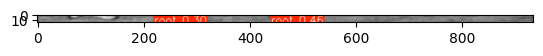

In [244]:
# rule
import matplotlib.pyplot as plt
%matplotlib inline
img = results[0].plot()
plt.imshow(img)

In [245]:
for result in results:
    for box in result.boxes.xywh:
        x, y, w, h = box  # x, y are center coordinates
        print(f"Bounding Box - X: {x}, Y: {y}, Width: {w}, Height: {h}")

Bounding Box - X: 451.579345703125, Y: 3.084888458251953, Width: 21.3880615234375, Height: 4.754453659057617
Bounding Box - X: 229.09979248046875, Y: 3.2426047325134277, Width: 17.188674926757812, Height: 4.622689247131348


In [246]:
# keys
segmentation_models.keys()

dict_keys(['full', 'early', 'late'])

In [247]:
# Define...
def get_segmented_images(image_paths, display_image=False):
    """Extracts and merges segments from images, 
    returning only images with detections."""

    for model in segmentation_models.keys():
        model = segmentation_models[model]
        results = model(image_paths, verbose=False)

        if len(results[0].boxes.xyxy) != 0:
            break

    if len(results[0].boxes.xyxy) == 0:
        # Incase of no detections, return all the images (Still thinking of better ways to overcome this)
        return [Image.open(img) for img in image_paths]
        
    segmented_images = []
    
    for img_path, result in zip(image_paths, results):
        original_image = Image.open(img_path)
        merged_image = Image.new("RGBA", original_image.size, (0, 0, 0, 0))
        
        # Skip if no detections
        if len(result.boxes.xyxy) == 0:
            continue 
            
        # Extract and paste segments
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box.tolist())
            segment = original_image.crop((x1, y1, x2, y2))
            merged_image.paste(segment, (x1, y1))
            
        segmented_images.append(merged_image)

    # Display Images
    if display_image and segmented_images:
        fig, axes = plt.subplots(1, len(segmented_images), figsize=(15, 10))
        if len(segmented_images) == 1:
            axes = [axes]
        for ax, img in zip(axes, segmented_images):
            ax.imshow(img)
            ax.axis("off")
        plt.show()

    return segmented_images

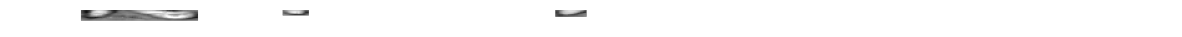

[<PIL.Image.Image image mode=RGBA size=934x14>]

In [248]:
# ...call
get_segmented_images([sample], display_image = True)

In [249]:
# The function retrieves images from a specified folder
# based on the scan side (left or right) and a layer range
# (from a starting layer to an ending layer).
def get_images_within_range(base_path: Path, folder: str, side: str, start: int, end: int) -> list[Path]:
    """
    Get images from a folder that match the specified side (L/R) and layer range.
    
    Args:
        base_path: Root directory containing all folders
        folder: Name of the target folder (e.g., 'Ypktwvqjbn')
        side: Scan side to filter ('L' or 'R')
        start: Starting layer (inclusive)
        end: Ending layer (inclusive)
    """
    folder_path = base_path / folder

    # Get all files in the folder
    try:
        images = os.listdir(folder_path)
    except FileNotFoundError:
        return []

    # Regex pattern to extract side and layer from filenames
    pattern = re.compile(r'_([LR])_(\d{3})\.png$')
    
    selected_images = []
    
    for img_name in images:
        match = pattern.search(img_name)
        if match:
            # Extract side and layer from filename
            img_side = match.group(1)
            layer = int(match.group(2))

    # Check if matches criteria
            if img_side == side and start <= layer <= end:
                selected_images.append(folder_path / img_name)
    
    return selected_images

In [250]:
# test and see
import re
sample_images = get_images_within_range(TRAIN_DATA_PATH, "Ypktwvqjbn", "L", 33, 41)
sample_images

[PosixPath('/kaggle/input/zindi-cgiar-files/data/train/Ypktwvqjbn/Ypktwvqjbn_L_041.png'),
 PosixPath('/kaggle/input/zindi-cgiar-files/data/train/Ypktwvqjbn/Ypktwvqjbn_L_037.png'),
 PosixPath('/kaggle/input/zindi-cgiar-files/data/train/Ypktwvqjbn/Ypktwvqjbn_L_039.png'),
 PosixPath('/kaggle/input/zindi-cgiar-files/data/train/Ypktwvqjbn/Ypktwvqjbn_L_036.png'),
 PosixPath('/kaggle/input/zindi-cgiar-files/data/train/Ypktwvqjbn/Ypktwvqjbn_L_034.png'),
 PosixPath('/kaggle/input/zindi-cgiar-files/data/train/Ypktwvqjbn/Ypktwvqjbn_L_033.png'),
 PosixPath('/kaggle/input/zindi-cgiar-files/data/train/Ypktwvqjbn/Ypktwvqjbn_L_040.png'),
 PosixPath('/kaggle/input/zindi-cgiar-files/data/train/Ypktwvqjbn/Ypktwvqjbn_L_038.png'),
 PosixPath('/kaggle/input/zindi-cgiar-files/data/train/Ypktwvqjbn/Ypktwvqjbn_L_035.png')]

In [251]:
get_segmented_images(sample_images, display_image = True)

[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=951x14>]

In [252]:
# finally merge all of the image segments into one
def merge_segmented_images(path: Path, folder: str, side: str, start: int, end: int):
    images_in_range = get_images_within_range(path, folder, side, start, end)
    segmented_images = get_segmented_images(images_in_range)

    # Determine final dimensions for the merged image
    total_width = sum(img.width for img in segmented_images)  # Sum of all widths
    max_height = max(img.height for img in segmented_images)  # Max height among all images

    # Create a blank canvas with a transparent background
    merged_image = Image.new("RGBA", (total_width, max_height), (0, 0, 0, 0))

    # Paste each segmented image next to the previous one (left to right)

    x_offset = 0
    for img in segmented_images:
        merged_image.paste(img, (x_offset, 0), img)  # Paste at correct position
        x_offset += img.width  # Move x-offset to the right for the next image

    return merged_image

In [253]:
merged_image = merge_segmented_images(TRAIN_DATA_PATH, "Ox18ob0syv", "R", 21, 28)
merged_image

In [254]:
OUTPUT_IMAGE_DIR = Path("/kaggle/working/merged_images/")
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok = True)

TRAIN_OUTPUT_DIR = OUTPUT_IMAGE_DIR / "Train"
TEST_OUTPUT_DIR = OUTPUT_IMAGE_DIR / "Test"

os.makedirs(TRAIN_OUTPUT_DIR, exist_ok = True)
os.makedirs(TEST_OUTPUT_DIR, exist_ok = True)

In [255]:
train_data.head()

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early


In [256]:
# Generate a new dataset
# Iterate through all the  images in the df
from tqdm import tqdm
def generate_merged_images(df: pd.DataFrame, output_path: Path, input_path: Path):
    gen_image_paths = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Merging Images"):
        gen_image = merge_segmented_images(
            path=input_path,
            folder=row["FolderName"],
            side=row["Side"],
            start=row["Start"],
            end=row["End"]
        )
        img_path = output_path / f"{row['ID']}.png"
        gen_image.save(img_path)
        gen_image_paths.append(img_path)

    df['ImageSegments'] = gen_image_paths
    return df

In [257]:
new_train_data = generate_merged_images(train_data, TRAIN_OUTPUT_DIR, TRAIN_DATA_PATH)

Merging Images: 100%|██████████| 386/386 [01:08<00:00,  5.60it/s]


In [258]:
new_train_data.head()

,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage,ImageSegments
0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early,/kaggle/working/merged_images/Train/ID_826322_...
1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early,/kaggle/working/merged_images/Train/ID_718181_...
2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early,/kaggle/working/merged_images/Train/ID_465762_...
3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early,/kaggle/working/merged_images/Train/ID_626872_...
4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early,/kaggle/working/merged_images/Train/ID_518846_...


In [259]:
new_test_data = generate_merged_images(test_data, TEST_OUTPUT_DIR, TEST_DATA_PATH)

Merging Images: 100%|██████████| 130/130 [00:22<00:00,  5.71it/s]


In [260]:
def display_generated_images(image_paths):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, img_path in enumerate(image_paths[:4]):  # Display first 4 images
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].axis("off")  # Hide axes
        axes[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

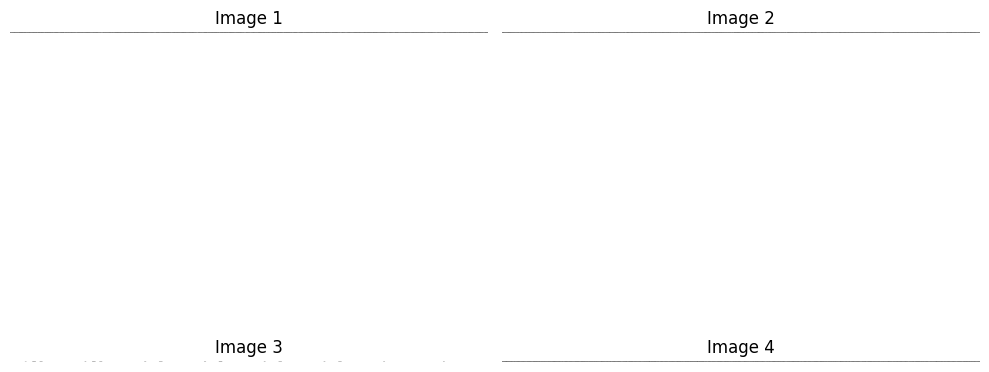

In [261]:
# Display Train
display_generated_images(new_train_data['ImageSegments'].values)

In [262]:
sample_image

In [263]:
# Model trainning
from torchvision.transforms import v2
train_transform = v2.Compose([
    v2.Resize(size=(20, 150), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])

# Testing Transform
test_transform = v2.Compose([
    v2.Resize(size=(20, 150), antialias=True),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])

img = train_transform(sample_image)
img.shape

torch.Size([4, 20, 150])

In [264]:
# checking
img.size

<function Image.size>

In [265]:
sample_image = Image.open(new_train_data['ImageSegments'].iloc[6])
train_transform(sample_image)

Image([[[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]],

       [[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]],

       [[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]],

       [[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., 

In [266]:
# define the dataset
from torch.utils.data import DataLoader, Dataset
class RootVolumeDataset(Dataset):
    def __init__(self, df : pd.DataFrame, transform = None, is_train = True):
        super().__init__()
        self.df = df
        self.transform = transform
        self.is_train = is_train

    def __getitem__(self, index):
        image = Image.open(self.df['ImageSegments'].iloc[index]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_train:
            label = self.df['RootVolume'].iloc[index]

            return image, torch.tensor(label, dtype=torch.float32)
        
        return image

    def __len__(self):
        return len(self.df)

In [267]:
train_dataset = RootVolumeDataset(new_train_data, train_transform)
test_dataset = RootVolumeDataset(new_test_data, test_transform, is_train = False)

In [268]:
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([3, 20, 150]), tensor(0.9000))

In [269]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [332]:
import torch
import torch.nn as nn
import pytorch_lightning as L
from torchvision import models

class RootVolumeRegressor(L.LightningModule):
    def __init__(self, lr=1e-3, freeze_backbone=False):
        super().__init__()
        self.lr = lr

        # Load a pre-trained EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        # Freeze the backbone (optional)
        if freeze_backbone:
            for param in self.efficientnet.parameters():
                param.requires_grad = False

        # Replace the classifier head with a regression head
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(self.efficientnet.classifier[1].in_features, 32),  # Adjust based on EfficientNet variant
            nn.ReLU(),
            nn.Linear(32, 1)  # Regression output
        )

        # Loss function
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.efficientnet(x).squeeze()  # Squeeze to remove extra dimensions

    def training_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images)
        loss = self.criterion(preds, targets)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images)
        loss = self.criterion(preds, targets)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Example usage
model = RootVolumeRegressor(freeze_backbone=True)  # Freeze backbone for transfer learning
print(model)

RootVolumeRegressor(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
         

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [333]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping
import numpy as np

# Define the number of folds
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store results for each fold
val_losses = []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Create Subsets for training and validation
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32)

    # Define a PyTorch Lightning Trainer
    trainer = L.Trainer(
        max_epochs=20,
        # callbacks=[EarlyStopping(monitor="val_loss", patience=3)],
        accelerator="auto",  # Use GPU if available
        devices="auto",
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Validate the model
    val_results = trainer.validate(model, val_loader)
    val_loss = val_results[0]["val_loss"]
    val_losses.append(val_loss)

    print(f"Validation Loss for Fold {fold + 1}: {val_loss}")

# Calculate average validation loss across all folds
avg_val_loss = np.mean(val_losses)
print(f"Average Validation Loss across {num_folds} folds: {avg_val_loss}")

Fold 1/5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     2.306999683380127     │
└───────────────────────────┴───────────────────────────┘

Validation Loss for Fold 1: 2.306999683380127
Fold 2/5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.8584420680999756     │
└───────────────────────────┴───────────────────────────┘

Validation Loss for Fold 2: 1.8584420680999756
Fold 3/5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.6296924352645874     │
└───────────────────────────┴───────────────────────────┘

Validation Loss for Fold 3: 1.6296924352645874
Fold 4/5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     2.705206871032715     │
└───────────────────────────┴───────────────────────────┘

Validation Loss for Fold 4: 2.705206871032715
Fold 5/5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.9017295837402344     │
└───────────────────────────┴───────────────────────────┘

Validation Loss for Fold 5: 2.9017295837402344
Average Validation Loss across 5 folds: 2.2804141283035277


In [327]:
def get_model_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds, targets = [], []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Predict
            preds.extend(outputs.cpu().numpy().flatten())
            targets.extend(labels.cpu().numpy().flatten())

    return np.array(preds), np.array(targets)

train_preds, target = get_model_preds(model, train_dataloader)

In [328]:
def calculate_rmse(preds, targets):
    """
    Compute Root Mean Squared Error (RMSE) between predictions and ground truth targets.
    """
    preds = np.array(preds) if not isinstance(preds, np.ndarray) else preds
    targets = np.array(targets) if not isinstance(targets, np.ndarray) else targets
    
    return np.sqrt(np.mean((preds - targets) ** 2))

calculate_rmse(train_preds, target)

1.4617926

In [329]:
def get_test_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds = []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images = batch if isinstance(batch, torch.Tensor) else batch[0]
            images = images.to(device)

            outputs = model(images)
            preds.extend(outputs.cpu().numpy().flatten()) 

    return np.array(preds)

test_preds = get_test_preds(model, test_dataloader)

In [330]:
test_data['RootVolume'] = test_preds
test_data.head()

,ID,FolderName,PlantNumber,Side,Start,End,Genotype,Stage,ImageSegments,RootVolume
0,ID_208667_Hnkl8q,L5l1h3kekg,7,L,38,50,IITA-TMS-IBA000070,Early,/kaggle/working/merged_images/Test/ID_208667_H...,2.040449
1,ID_285249_Jnjvav,Wgutyon8uu,6,R,23,37,TMEB419,Early,/kaggle/working/merged_images/Test/ID_285249_J...,2.154042
2,ID_697947_Yec6bd,Mylwjeq6tq,3,R,19,42,IBA980581,Early,/kaggle/working/merged_images/Test/ID_697947_Y...,2.205022
3,ID_534638_X3j91f,Pfp24vx905,2,R,27,34,TMEB419,Early,/kaggle/working/merged_images/Test/ID_534638_X...,2.135269
4,ID_929298_Xvymuz,Mrw7chmalv,4,R,30,43,IBA154810,Early,/kaggle/working/merged_images/Test/ID_929298_X...,2.030666


In [331]:
submission = test_data[['ID', 'RootVolume']]
submission.to_csv("submission.csv", index = False)
submission.head()

,ID,RootVolume
0,ID_208667_Hnkl8q,2.040449
1,ID_285249_Jnjvav,2.154042
2,ID_697947_Yec6bd,2.205022
3,ID_534638_X3j91f,2.135269
4,ID_929298_Xvymuz,2.030666


In [311]:
end = time.time()
expected = (end - start) / 60
print('Expected runtime for this notebook is: {:.2f} minutes.'.format(expected))

Expected runtime for this notebook is: 17.57 minutes.


In [312]:
## BEST SCORE (LOCAL): 1.494953884 | 1.3672612691 | 1.5101789 | 1.4497778 | 1.392078
## BEST SCORE (ZINDI): 1.084303563 | 1.079255528 | 1.061416456 | 1.034779094 | 1.03061685
## BEST RANK: 229 | 186 | 126 | 94 | 92
## BEST TIME: 0.19 minutes